In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.environ['rapp'])
from rayleigh_diagnostics import Shell_Spectra, Shell_Slices, GridInfo
from reference_tools import equation_coefficients
sys.path

['/pleiades/home1/lmatilsk/rayleigh/utils/test_equations',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python37.zip',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/lib-dynload',
 '',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/site-packages',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/site-packages/IPython/extensions',
 '/lou/la2/lmatilsk/.ipython',
 '/home1/lmatilsk/rayleigh/code/post_processing']

In [2]:
dirname = '/nobackup/lmatilsk/benchmarks/j2011_mhd/00_test_equations_indt/'
#dirname = '/nobackup/lmatilsk/case_M-Prm4.0/00_1k_iters_spec_indr/'

In [3]:
radatadir = dirname + 'Shell_Spectra/'
the_file = radatadir + os.listdir(radatadir)[0]
spec = Shell_Spectra(the_file,'')
print(the_file)

/nobackup/lmatilsk/benchmarks/j2011_mhd/00_test_equations_indt/Shell_Spectra/15000100


In [4]:
radatadir = dirname + 'Shell_Slices/'
the_file = radatadir + os.listdir(radatadir)[0]
sslice = Shell_Slices(the_file,'')
print(the_file)

/nobackup/lmatilsk/benchmarks/j2011_mhd/00_test_equations_indt/Shell_Slices/15000100


In [5]:
# break up shell spectra data
vals = spec.vals
vals_ss = sslice.vals

times =  spec.time
dt = times[2:] - times[1:-1]
dt = dt.reshape((1, 1, 1, len(dt)))
dt_old = times[1:-1] - times[:-2]
dt_old = dt_old.reshape((1, 1, 1, len(dt_old)))

lut = spec.lut
lut_ss = sslice.lut
irvals = spec.inds

print ('irvals = ', irvals)

irvals =  [ 18  29  42  53  63  74  85  98 109]


In [6]:
print (np.shape(vals))

(128, 128, 9, 3, 100)


In [7]:
# pick a radial location
ir0 = 4
print ('rad =', spec.radius[ir0]/6.96e10)

rad = 0.06828907833209069


In [8]:
# get rotation period (for time axis)
eq = equation_coefficients()
eq.read(dirname + 'equation_coefficients')
Om0 = eq.constants[0]/2
prot = 2*np.pi/Om0
t = times/prot

In [9]:
# check if timestep changes (usually doesn't over 1000 iters)
print(np.mean(np.diff(times)))
print(np.std(np.diff(times)))
print (len(times))

200.0
0.0
100


In [10]:
np.abs(1+1j)

1.4142135623730951

In [11]:
gi=GridInfo(dirname + 'grid_info', '')
tw = gi.tweights.reshape((gi.ntheta, 1, 1))
print (np.shape(tw))
print (np.shape(vals_ss))

(192, 1, 1)
(384, 192, 9, 3, 100)


In [12]:
# integrate total power over spherical surface
def my_abs(arr, sslice=False):
    out = np.abs(arr)**2
    if sslice:
        out = np.mean(out, axis=0)
        out = np.sum(out*tw, axis=0)
    else:
        out = np.sum(np.sum(out, axis=0), axis=0)/(4*np.pi)
    return np.sqrt(out)

In [13]:
# r induct
b = vals[..., lut[802], :]

fexp = induct = vals[..., lut[1609], :]

fimp = diff = vals[..., lut[1610], :]

# sslice

b_ss = vals_ss[..., lut_ss[802], :]

fexp_ss = induct_ss = vals_ss[..., lut_ss[1609], :]

fimp_ss = diff_ss = vals_ss[..., lut_ss[1610], :]

In [14]:
# get lhs = d var / dt
def get_ddt(variable):
    dvar = variable[..., 2:] - variable[..., 1:-1]
    return dvar/dt

dbdt = get_ddt(b)
dbdt_ss = get_ddt(b_ss)

In [15]:
# get weighted rhs

def get_weighted_rhs(fimp, fexp):
    return 0.5*(fimp[..., 2:] + fimp[..., 1:-1]) + fexp[..., 1:-1] +\
        0.5*(dt/dt_old)*(fexp[..., 1:-1] - fexp[..., :-2])

fweighted = get_weighted_rhs(fimp, fexp)

fweighted_ss = get_weighted_rhs(fimp_ss, fexp_ss)

Text(0.5, 1.0, 'induct (t) spec')

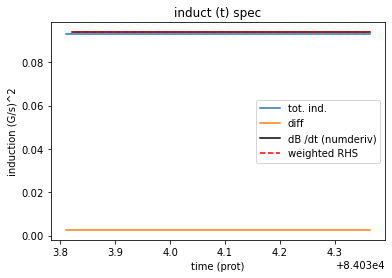

In [16]:
# plot r induct(all pieces)

# pieces
plt.plot(t, my_abs(induct)[ir0, :], label='tot. ind.')
plt.plot(t, my_abs(diff)[ir0, :], label='diff')

# totals
plt.plot(t[2:], my_abs(dbdt)[ir0, :], 'k', label='dB /dt (numderiv)')
plt.plot(t[2:], my_abs(fweighted)[ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)^2')
plt.title('induct (t) spec')

Text(0.5, 1.0, 'induct totals (t) spec')

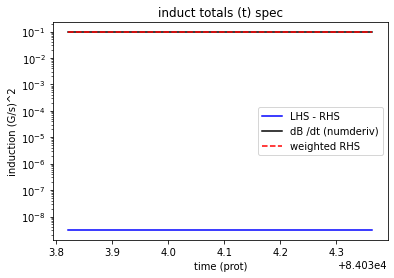

In [17]:
# plot r induct (totals)
plt.plot(t[2:], my_abs(dbdt - fweighted)[ir0, :], 'b', label='LHS - RHS')
plt.plot(t[2:], my_abs(dbdt)[ir0, :], 'k', label='dB /dt (numderiv)')
plt.plot(t[2:], my_abs(fweighted)[ir0, :], 'r--', label='weighted RHS')
plt.yscale('log')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)^2')
plt.title('induct totals (t) spec')

Text(0.5, 1.0, 'induct (t) sslice')

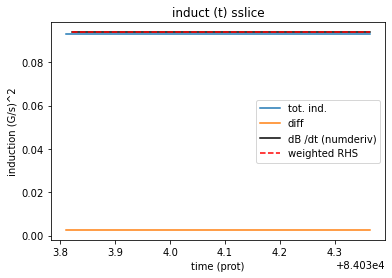

In [18]:
# plot r induct(all pieces)

# pieces
plt.plot(t, my_abs(induct_ss, sslice=True)[ir0, :], label='tot. ind.')
plt.plot(t, my_abs(diff_ss, sslice=True)[ir0, :], label='diff')

# totals
plt.plot(t[2:], my_abs(dbdt_ss, sslice=True)[ir0, :], 'k', label='dB /dt (numderiv)')
plt.plot(t[2:], my_abs(fweighted_ss, sslice=True)[ir0, :], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)^2')
plt.title('induct (t) sslice')

Text(0.5, 1.0, 'induct totals (t) sslice')

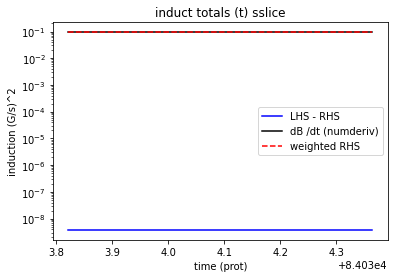

In [19]:
# plot r induct (totals)
plt.plot(t[2:], my_abs(dbdt_ss - fweighted_ss, sslice=True)[ir0, :], 'b', label='LHS - RHS')
plt.plot(t[2:], my_abs(dbdt_ss, sslice=True)[ir0, :], 'k', label='dB /dt (numderiv)')
plt.plot(t[2:], my_abs(fweighted_ss, sslice=True)[ir0, :], 'r--', label='weighted RHS')
plt.yscale('log')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)^2')
plt.title('induct totals (t) sslice')

In [20]:
# plot the errors on spectra
irvals = np.arange(spec.nr)

Text(0.5, 1.0, 'induct err (t) spec')

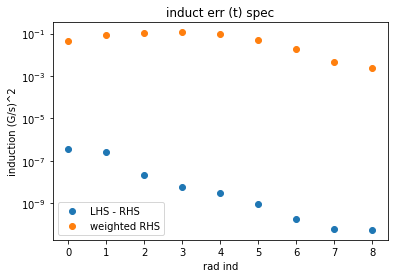

In [21]:
plt.scatter(irvals, np.mean(my_abs(dbdt - fweighted), axis=1), label='LHS - RHS')
plt.scatter(irvals, np.mean(my_abs(fweighted), axis=1), label='weighted RHS')
plt.legend()
plt.yscale('log')
plt.xlabel('rad ind')
plt.ylabel('induction (G/s)^2')
plt.title('induct err (t) spec')

Text(0.5, 1.0, 'induct err (t) sslice')

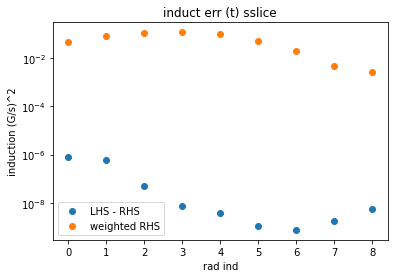

In [22]:
plt.scatter(irvals, np.mean(my_abs(dbdt_ss - fweighted_ss, sslice=True), axis=1), label='LHS - RHS')
plt.scatter(irvals, np.mean(my_abs(fweighted_ss, sslice=True), axis=1), label='weighted RHS')
plt.legend()
plt.yscale('log')
plt.xlabel('rad ind')
plt.ylabel('induction (G/s)^2')
plt.title('induct err (t) sslice')

Text(0.5, 1.0, 'meprod totals (t) sslice')

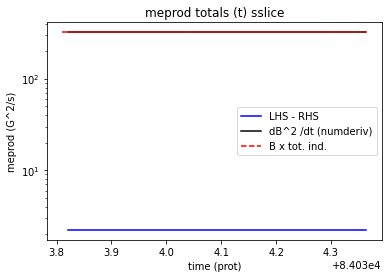

In [23]:
# get energy equation (B x induction) on the shell slices
tot_ss = induct_ss + diff_ss
meprod = tot_ss * b_ss
db2dt = get_ddt(b_ss**2)/2

# plot r induct (totals)
plt.plot(t[2:], my_abs(db2dt - meprod[...,1:-1], sslice=True)[ir0, :], 'b', label='LHS - RHS')
plt.plot(t[2:], my_abs(db2dt, sslice=True)[ir0, :], 'k', label='dB^2 /dt (numderiv)')
plt.plot(t, my_abs(meprod, sslice=True)[ir0, :], 'r--', label='B x tot. ind.')
plt.yscale('log')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('meprod (G^2/s)')
plt.title('meprod totals (t) sslice')